# 5 Dimensionality reduction

## Aim
- Reduce the dimensionality of the spectral data for visualization and further analysis
- Eliminate noise in the spectral data

## Checking the data quality

(242, 233, 233)
242


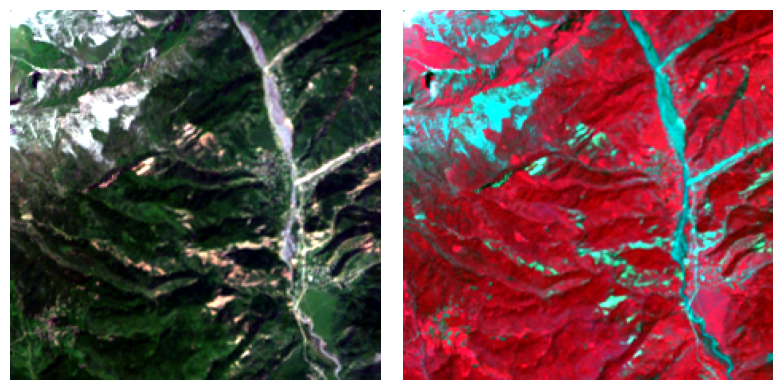

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

path = "C:/Users/louis/Desktop\Hyperspectral Remote Sensing/Sheet05/data"

image_path = f"{path}/EO1H1510312010165110KF_L1T.tif"
wl_path = f"{path}/hyperion.txt"

# for PCA the whole image is fine; I will reduce later for isomap
image = rasterio.open(image_path)
image_data = image.read()
wl = np.loadtxt(wl_path)

print(image_data.shape)
print(len(wl))

# this replaces the stretch='lin'
def linear_stretch(band, lower_percent=2, upper_percent=98):
    
    lower = np.percentile(band, lower_percent)
    upper = np.percentile(band, upper_percent)    
    # Clip and scale
    stretched_band = np.clip(band, lower, upper)
    stretched_band = (stretched_band - lower) / (upper - lower)
    return stretched_band


band10 = linear_stretch(image_data[10])     
band20 = linear_stretch(image_data[20])   
band30 = linear_stretch(image_data[30])  
band45 = linear_stretch(image_data[45])

# stacks
rgb = np.dstack((band30, band20, band10))
nir_rg = np.dstack((band45, band30, band20))

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nir_rg)
plt.axis('off')
plt.tight_layout()
plt.show()

#### Q5.1 (2 pts) 
Plot the image as NIR/Red/Green false color composite. Which band combination is suitable for
this purpose? Briefly describe the study area in terms of forest cover, water bodies, etc.

**Answer:** Bands 10, 20, 30, 45 as I used above seem to be suitable. The study area features dense forest cover (dark green in the true-color image, red in the false-color image) and water bodies, including rivers and streams (cyan/blue in the false-color image). There appears to be snow higher up on the mountain.

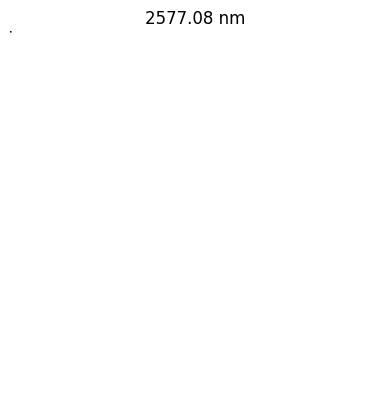

In [23]:
from IPython.display import clear_output
import time

for i in range(image_data.shape[0]):
    clear_output(wait=True)
    plt.imshow(image_data[i], cmap='gray')
    plt.title(f"{wl[i]} nm")
    plt.axis('off')
    plt.show()
    time.sleep(1)

In [2]:
# c ( 1 : 7 , 58: 78, 121 : 127 , 167 : 178, 224 : 242 )
badbands = list(range(0, 7)) + list(range(57, 78)) + list(range(120, 127)) + list(range(166, 178)) + list(range(223, 242))
goodbands = [i for i in range(len(wl)) if i not in badbands]


image_data = image_data[goodbands]
wl = np.delete(wl, badbands)

number_bands, rows, cols = image_data.shape

print(f"remaining bands: {number_bands}")

remaining bands: 176


## Principal component analysis

### Q5.2 (3 pts) 
The PCA can be used with and without scaling and centering the data. What is the difference
between these two modes? How does this affect the influence that the individual bands get in the
dimensionality reduction?

**Anwer:** Without scaling the PCA operates on the raw data; bands with higher variability will disproportionately influence the principal components, regardless of their actual importance to the dataset (and smaller-scale features are underrepresented). With scaling (standard deviation of each feature set to 1) and mean-centering (subtracting the mean of each feature) no features have a higher variability. Therefore the PCA identifies components based purely on correlation and variance; each band contributes equally to the analysis. This is often the preferred mode.

[10.153744, 7.431142, 2.4710653, 1.7652766, 1.1103865]


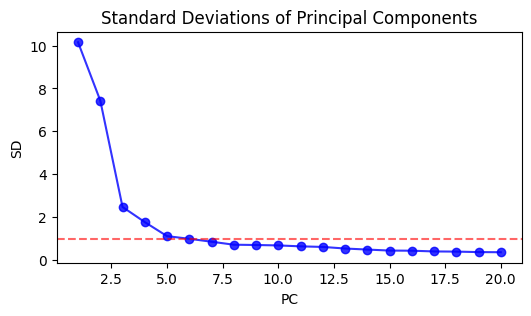

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

impix = image_data.reshape(number_bands, -1).T

# Scale
scaler = StandardScaler()
impix_scaled = scaler.fit_transform(impix)

# PCA from sklearn automatically centers
pca = PCA()
pca_results = pca.fit_transform(impix_scaled)

sdev = np.sqrt(pca.explained_variance_)
print([sd for sd in sdev if sd>1])

plt.figure(figsize=(6,3))
plt.plot(range(1, 21), sdev[:20], marker='o', linestyle='-', color='b', alpha=0.8)
plt.axhline(y=1, color='#FF0000', linestyle='--', alpha=0.6)
plt.xlabel('PC')
plt.ylabel('SD')
plt.title('Standard Deviations of Principal Components')
plt.show()


### Q5.3 (1 pt) 
Which PCs have an information load > 1SD?

**Anwer:** The first five PCs have an information load over 1 SD.

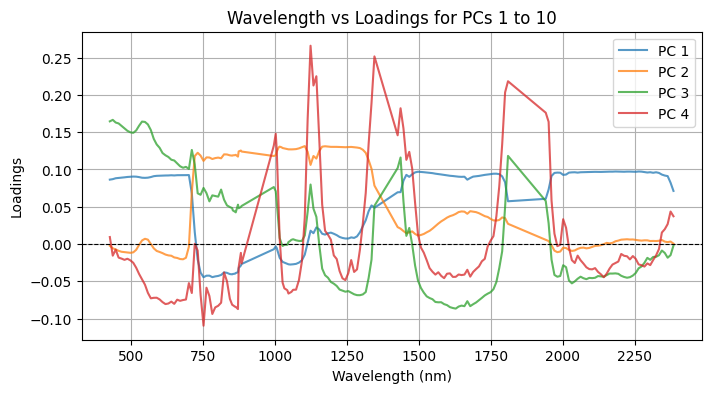

In [4]:
loadings = pca.components_.T
# Loadings for the first three bands on PC1: loadings[:3, 0]

plt.figure(figsize=(8, 4))
for pc in range(4):    # the last 6 seem to indicate noise, so I removed them for a smoother plot
    plt.plot(wl, loadings[:, pc], label=f"PC {pc+1}", alpha=0.75)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Loadings")
plt.title("Wavelength vs Loadings for PCs 1 to 10")
plt.legend()
plt.grid()
plt.show()


### Q5.4 (3 pts) 
Plot wavelength vectors against the loadings of PC 1 10 and assess their distribution. Which
PCs show a clear pattern, which indicate noise?

**Answer:** PCs 5-10 clearly seemed to indicate noise with jagged patterns; higher PCs typically capture less variance. I have removed them from the plot for a smoother view of the first 4 PCs, which show clear patterns.

In [4]:
# NDVI
nir_band = 37
red_band = 20
print(wl[nir_band], wl[red_band])
ndvi = (impix[:, nir_band] - impix[:, red_band]) / (impix[:, nir_band] + impix[:, red_band])

print(ndvi.min(), ndvi.max())
ndvi_normalized = np.round(255 * (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())).astype(int)

803.3 630.32
-0.23120974 0.71028036


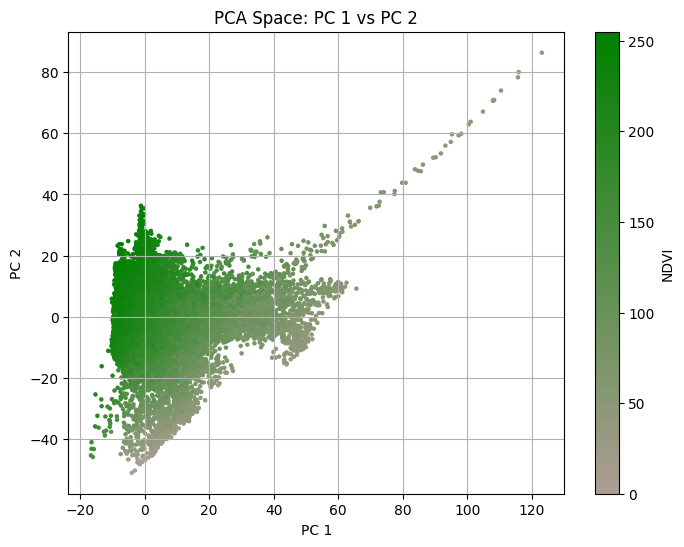

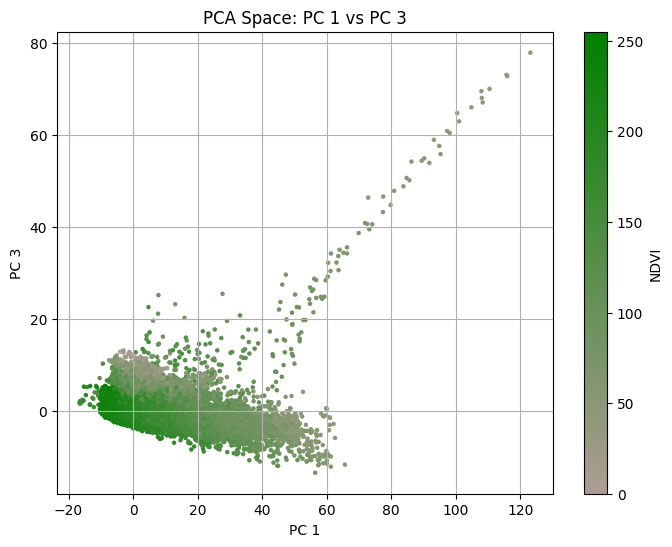

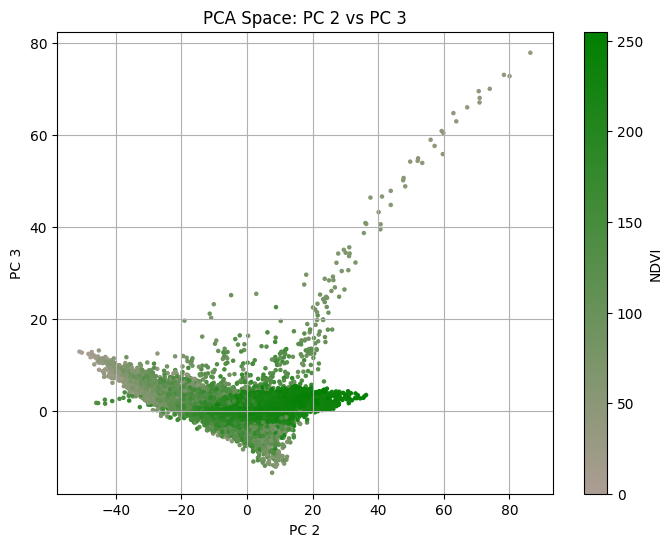

In [19]:
from matplotlib.colors import LinearSegmentedColormap

# color map
ndvi_colors = LinearSegmentedColormap.from_list("NDVI", ["#ac9d93", "#008000"], N=256)

def plot_pca_space(pc_x, pc_y, x_label, y_label):
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_results[:, pc_x], pca_results[:, pc_y], 
                c=ndvi_normalized, cmap=ndvi_colors, s=5)
    plt.colorbar(label="NDVI")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"PCA Space: {x_label} vs {y_label}")
    plt.grid()
    plt.show()

plot_pca_space(0, 1, "PC 1", "PC 2") 
plot_pca_space(0, 2, "PC 1", "PC 3") 
plot_pca_space(1, 2, "PC 2", "PC 3") 


### Q5.5 (1 pt) 
How are vegetated and non vegetated pixels distributed on the PCs?

**Answer:** Vegetated pixels (higher NDVI values) are clustered/seperated in PCA space. Non-vegetated pixels are more scattered and extend along the axes, indicating greater variability in their spectral features. The first plot with PC 1 and 2 show the clearest separation between vegetated and non-vegetated pixels.

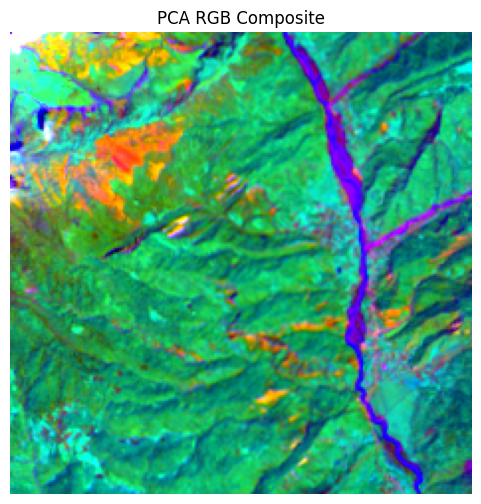

In [15]:
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as plt

# reshaping PCA back to the image dimensions
pca_image = pca_results.T.reshape(number_bands, rows, cols)

def plot_rgb_pca(pca_image):
    
    pc1 = linear_stretch(pca_image[0])
    pc2 = linear_stretch(pca_image[1])
    pc3 = linear_stretch(pca_image[2])
    rgb = np.dstack((pc1, pc2, pc3))

    plt.figure(figsize=(6, 6))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("PCA RGB Composite")
    plt.show()

plot_rgb_pca(pca_image)

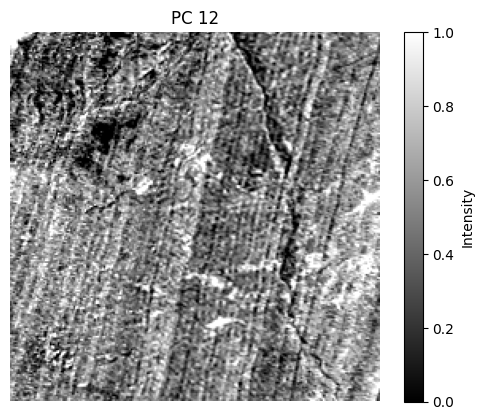

In [16]:

for i in range(12):
    clear_output(wait=True) 
    stretched_band = linear_stretch(pca_image[i])
    plt.imshow(stretched_band, cmap='gray')
    plt.title(f"PC {i+1}")
    plt.axis('off')
    plt.colorbar(label="Intensity")
    plt.show()
    time.sleep(1)


## Minimum Noise Fractioning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# back-transform PCA into spectral bands
def backrot(scores, loadings, scale, center, num_pcs):

    reconstructed = np.dot(scores[:, :num_pcs], loadings[:, :num_pcs].T) * scale + center
    return np.floor(reconstructed)

scale = scaler.scale_  
center = scaler.mean_  

num_pcs = 3
mnfval = backrot(pca_results, loadings, scale, center, num_pcs)

### Q5.6 (3 pts) 
Plot the spectra of a few random pixels before and after the MNF transformation. Did the shape
and magnitude of the spectra change? Add a plot of a few spectra before and after to your report.

**Answer:** After the MNF transformation, the magnitude of the spectra remains largely unchanged, but the shapes seem smoother; so the noise reduction seemed to work, reducing jagged, noisy features in the spectra.  Also interesting to see is the orange line, which before occasionally appears above the red line. After the transformation, it seems to merge with the red line, disappearing behind it. This indicates that the MNF transformation makes similar pixels more spectrally uniform, enhancing their similarity.

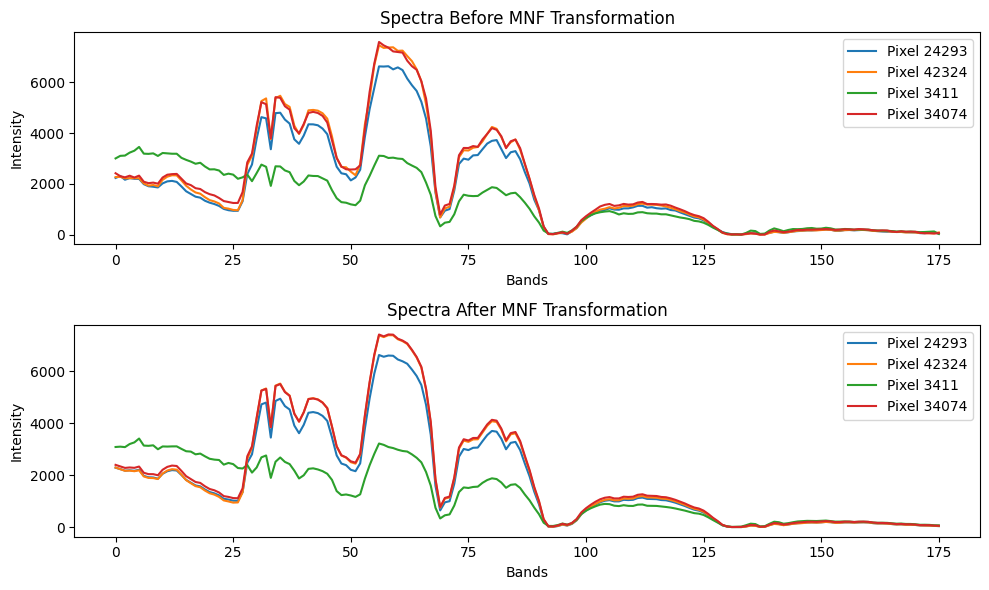

In [33]:
# Plot spectra of random pixels before and after
random_pixels = np.random.choice(impix.shape[0], size=4, replace=False) 

plt.figure(figsize=(10, 6))

for i, pixel in enumerate(random_pixels):
    plt.subplot(2, 1, 1)
    plt.plot(impix[pixel], label=f'Pixel {pixel + 1}')
    plt.title('Spectra Before MNF Transformation')
    plt.xlabel('Bands')
    plt.ylabel('Intensity')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(mnfval[pixel], label=f'Pixel {pixel + 1}')
    plt.title('Spectra After MNF Transformation')
    plt.xlabel('Bands')
    plt.ylabel('Intensity')
    plt.legend()

plt.tight_layout()
plt.show()


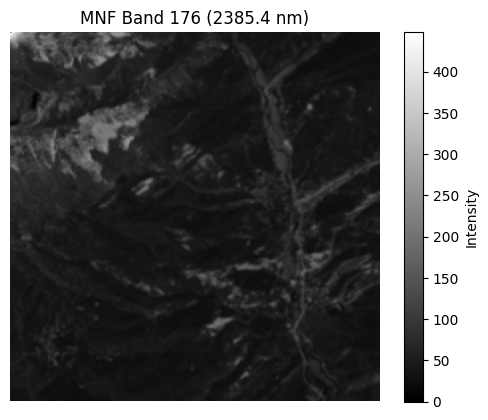

In [47]:
mnf_image = mnfval.T.reshape(number_bands, rows, cols)

for i in range(number_bands):
    clear_output(wait=True)
    plt.imshow(mnf_image[i], cmap='gray')
    plt.title(f"MNF Band {i+1} ({wl[i]} nm)")
    plt.axis('off')
    plt.colorbar(label="Intensity")
    plt.show()
    time.sleep(0.4)

### Q5.7 (1pt) 
Was the operation successful?

**Answer:** Yes, I actually did not see any noisy images anymore.

## Isometric Feature Mapping (ISOMAP)

In [20]:
# now I am actually getting memory errors with ISOMAP and have to reduce the image size
crop_size = 100
center_row, center_col = rows // 2 +60, cols // 2 +60
start_row = max(center_row - crop_size // 2, 0)
end_row = min(center_row + crop_size // 2, rows)
start_col = max(center_col - crop_size // 2, 0)
end_col = min(center_col + crop_size // 2, cols)

cropped_image_data = image_data[:, start_row:end_row, start_col:end_col]
print("Cropped Image Shape:", cropped_image_data.shape)

Cropped Image Shape: (176, 100, 100)


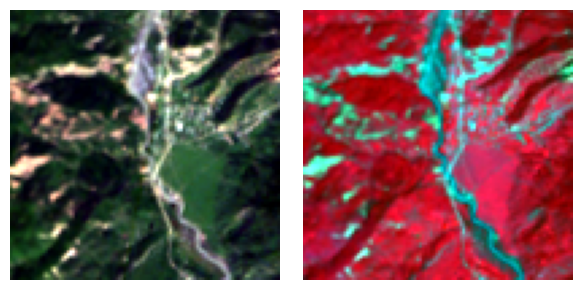

In [21]:
band10_cropped = band10[start_row:end_row, start_col:end_col]
band20_cropped = band20[start_row:end_row, start_col:end_col] 
band30_cropped = band30[start_row:end_row, start_col:end_col]
band45_cropped = band45[start_row:end_row, start_col:end_col]

# stacks
rgb = np.dstack((band30_cropped, band20_cropped, band10_cropped))
nir_rg = np.dstack((band45_cropped, band30_cropped, band20_cropped))

plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(nir_rg)
plt.axis('off')
plt.tight_layout()
plt.show()

In [22]:
impix_cropped = cropped_image_data.reshape(number_bands, -1).T

# Scale
scaler_cropped = StandardScaler()
impix_cropped_scaled = scaler_cropped.fit_transform(impix_cropped)

In [14]:
from sklearn.manifold import Isomap

isomap = Isomap(n_neighbors=10, n_components=3)
isomap_result = isomap.fit_transform(impix_cropped_scaled)

In [23]:
ndvi = (impix_cropped[:, nir_band] - impix_cropped[:, red_band]) / (impix_cropped[:, nir_band] + impix_cropped[:, red_band])
print(ndvi.min(), ndvi.max())
ndvi_normalized = np.round(255 * (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())).astype(int)

-0.21367522 0.6565574


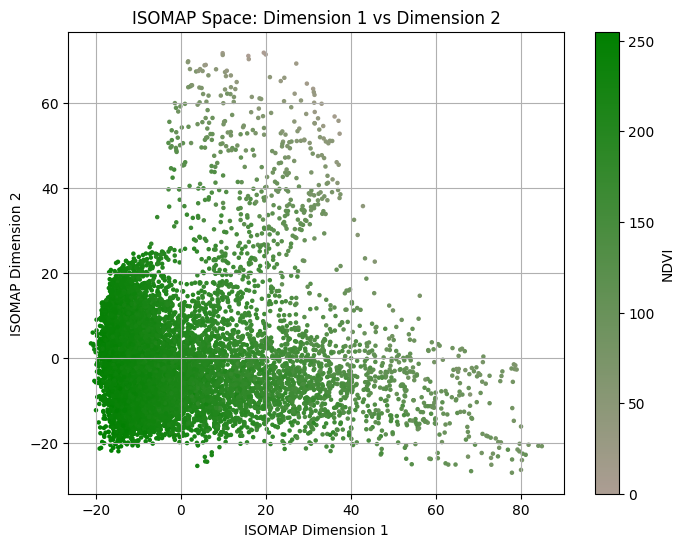

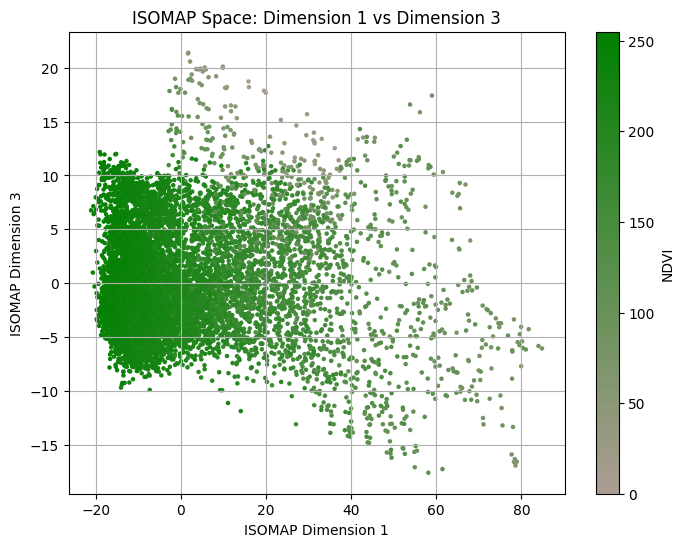

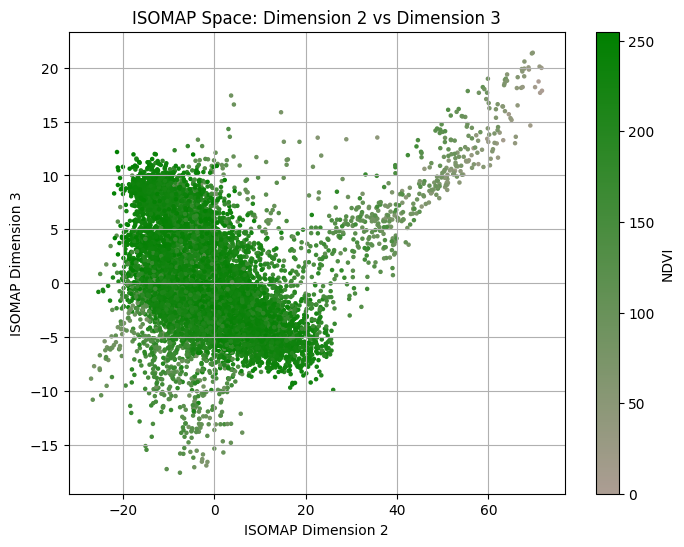

In [24]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(isomap_result[:, 0], isomap_result[:, 1], c=ndvi_normalized, cmap=ndvi_colors, s=5)
plt.colorbar(label="NDVI")
plt.xlabel("ISOMAP Dimension 1")
plt.ylabel("ISOMAP Dimension 2")
plt.title("ISOMAP Space: Dimension 1 vs Dimension 2")
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(isomap_result[:, 0], isomap_result[:, 2], c=ndvi_normalized, cmap=ndvi_colors, s=5)
plt.colorbar(label="NDVI")
plt.xlabel("ISOMAP Dimension 1")
plt.ylabel("ISOMAP Dimension 3")
plt.title("ISOMAP Space: Dimension 1 vs Dimension 3")
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(isomap_result[:, 1], isomap_result[:, 2], c=ndvi_normalized, cmap=ndvi_colors, s=5)
plt.colorbar(label="NDVI")
plt.xlabel("ISOMAP Dimension 2")
plt.ylabel("ISOMAP Dimension 3")
plt.title("ISOMAP Space: Dimension 2 vs Dimension 3")
plt.grid()
plt.show()

### Q5.8 (2 pt) 
Does the ISOMAP distribution of vegetated and non vegetated pixels differ from the PCA
distribution?

**Answer:** While the non-vegetated pixels are even more scattered in the ISOMAP images here, the vegetated pixels seem to be better seperated than in the PCA distribution (especially for the first two images). PCA focuses on maximizing variance, which may result in a less clear separation. ISOMAP appears to capture the (non-linear) structure of the data more effectively than PCA.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


r_iso range: 0.0 to 1.0
g_iso range: 0.0 to 1.0
b_iso range: 0.0 to 1.0000001192092896


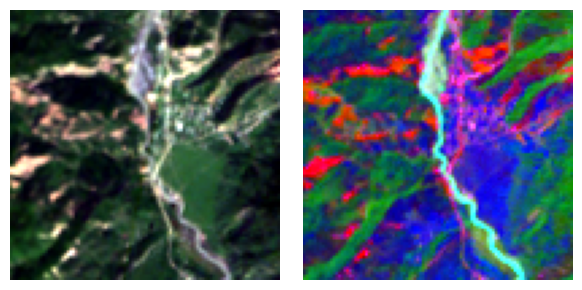

In [25]:
isomap_image = isomap_result.T.reshape(3, crop_size, crop_size)

r_iso = linear_stretch(isomap_image[0])
g_iso = linear_stretch(isomap_image[1])
b_iso = linear_stretch(isomap_image[2])
print(f"r_iso range: {r_iso.min()} to {r_iso.max()}")
print(f"g_iso range: {g_iso.min()} to {g_iso.max()}")
print(f"b_iso range: {b_iso.min()} to {b_iso.max()}")
rgb_iso = np.dstack((r_iso, g_iso, b_iso))

plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rgb_iso)
plt.axis('off')
plt.tight_layout()
plt.show()

### Q5.9 (1 pt) 
Is ISOMAP successfully removing the noise from the image data?

Some noise reduction seems to be there. The ISOMAP image, shows a clearer separation of features such as the river and surrounding landforms. The three grayscale images below (individual ISOMAP dimensions) also highlight different structural components of the landscape with reduced noise compared to the original image (especially in the second image).

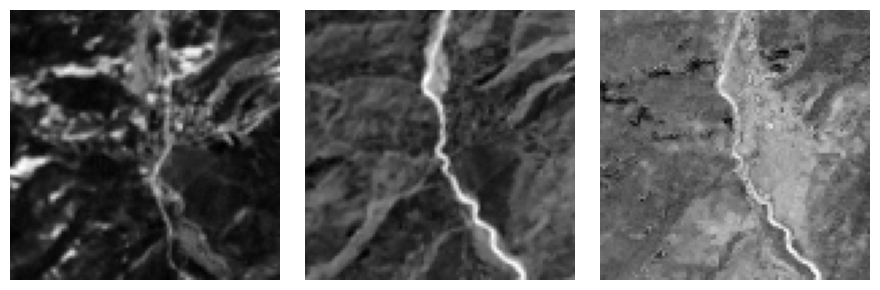

In [28]:
plt.figure(figsize=(9,3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(isomap_image[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Q5.10 (3pts): 
Read the paper by Wang et al. and come up with one (or more) question(s) that address(es)
the paper and its methodology.

**My Question:**
The authors state that the main advantages over simple KNN are (1) the probabilistic nature of their method and (2) the reduced memory storage.

(1) What are (their) main reasons for using probabilistic classification? Could simple KNN be adapted to be probabilistic?

(2) It would be really interesting to see how PCA+KNN and ISOMAP+KNN would have performed, since it would significantly reduce memory requirements. Would it show similar performance as plain KNN or even improve accuracy?
